In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-10-04 16:57:41--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-10-04 16:57:42 (23.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
!pip install torchsummaryX wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=0fd5de308ae320a3f56dbcdac7c1d82335c72f162bcabcf941f3eccfb279e851
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
import wandb

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
with open('input.txt', 'r') as f:
    text = f.read()

print(len(text))

1115394


In [ ]:
vocabulary = sorted(list(set(text)))
vocab_size = len(vocabulary)
print(vocabulary)
print(vocab_size)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65


In [ ]:
vocab_to_int = {v:i for i, v in enumerate(vocabulary)}
int_to_vocab = {i:v for i, v in enumerate(vocabulary)}

encode = lambda x: [vocab_to_int[i] for i in x]
decode = lambda x: "".join([int_to_vocab[i] for i in x])

enc_text = "Hi there!"
enc = encode(enc_text)
dec = decode(enc)
print(enc)
print(dec)

[20, 47, 1, 58, 46, 43, 56, 43, 2]
Hi there!


In [ ]:
decode([20, 47, 1, 58, 46, 43, 56, 43, 2])

'Hi there!'

In [ ]:
dataset = torch.tensor(encode(text), dtype = torch.long)
train_data = dataset[:int(0.9 * len(dataset))]
val_data = dataset[int(0.9 * len(dataset)): int(0.97 * len(dataset))]
test_data = dataset[int(0.97 * len(dataset)): ]

In [ ]:
class ShaksphereDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, seq_len, batch_size):
        self.dataset = dataset
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.sub_seq = (len(dataset) // self.seq_len)
        self.num_batches = self.sub_seq // self.batch_size

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        offsets = torch.randperm(len(self.dataset) - self.seq_len)[:self.sub_seq]
        inputs = torch.stack([self.dataset[i: i + self.seq_len] for i in offsets])
        outputs = torch.stack([self.dataset[i + 1: i + 1 + self.seq_len] for i in offsets])
        rem = inputs.shape[0] % self.batch_size
        if rem != 0:
            inputs = inputs[:-rem, :].reshape(self.num_batches, self.batch_size, self.seq_len)
            outputs = outputs[:-rem, :].reshape(self.num_batches, self.batch_size, self.seq_len)
        else:
            inputs = inputs.reshape(self.num_batches, self.batch_size, self.seq_len)
            outputs = outputs.reshape(self.num_batches, self.batch_size, self.seq_len)

        batch_idx = 0
        while batch_idx < self.num_batches:
            yield inputs[batch_idx, : , :].to(device), outputs[batch_idx, :, :].to(device)
            batch_idx = batch_idx + 1





In [ ]:
ModelConfig = {
    'seq_len': 256,
    "batch_size": 128,
    'embed_dim': 512,
    'qk_dim': 512
}

seq_len = ModelConfig['seq_len']
batch_size = ModelConfig['batch_size']
embed_dim = ModelConfig['embed_dim']
qk_dim = ModelConfig['qk_dim']
value_dim = ModelConfig['embed_dim']
model_size = ModelConfig['embed_dim']

In [ ]:
train_loader = ShaksphereDataLoader(train_data, seq_len = ModelConfig['seq_len'], batch_size = ModelConfig['batch_size'])
val_loader = ShaksphereDataLoader(val_data, seq_len = ModelConfig['seq_len'], batch_size = ModelConfig['batch_size'])
print(len(train_loader))
print(len(val_loader))

30
2


In [ ]:
for i in train_loader:
    x, y = i[0], i[1]
    break
print(x.shape)
print(y.shape)

torch.Size([128, 256])
torch.Size([128, 256])


In [ ]:
print(x.device)
print(y.device)

cpu
cpu


In [ ]:
class MaskedAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.query_layer = torch.nn.Linear(embed_dim, embed_dim, bias = False)
        self.key_layer = torch.nn.Linear(embed_dim, qk_dim, bias = False)
        self.value_layer = torch.nn.Linear(embed_dim, value_dim, bias = False)
        self.mask = torch.tril(torch.ones(seq_len, seq_len)).to(device)



    def forward(self, tok_embeddings, return_attention_weights = False):
        B, T, C = tok_embeddings.shape
        Q = self.query_layer(tok_embeddings) # (B, T, qk)
        K = self.key_layer(tok_embeddings)   # (B, T, qk)
        V = self.value_layer(tok_embeddings) # (B, T, v)

        affinities = (Q @ K.transpose(-1, -2)) * K.shape[-1] ** -0.5 # (B, T, T)
        affinities = affinities.masked_fill(self.mask[:T, :T] == 0, float('-inf'))

        attention_weights = F.softmax(affinities, dim = -1) # (B, T, T)

        if return_attention_weights:
            return attention_weights @ V, attention_weights
        return attention_weights @ V  # (B, T, v)

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.mini_head_size = int(self.head_size / self.num_heads)

        self.query = torch.nn.Linear(embed_dim, self.head_size)
        self.key = torch.nn.Linear(embed_dim, self.head_size)
        self.value = torch.nn.Linear(embed_dim, self.head_size)
        self.up_project = torch.nn.Linear(self.num_heads * self.mini_head_size, head_size)
        self.mask = torch.tril(torch.ones(seq_len, seq_len)).to(device)



    def forward(self, tok_embeddings, return_attention_weights = False):
        B, T, C = tok_embeddings.shape
        Q = self.query(tok_embeddings)
        K = self.key(tok_embeddings)
        V = self.value(tok_embeddings)

        # Reshape into N sub heads for parallel processing
        mini_Q = Q.view(B, T, self.num_heads, self.mini_head_size).permute(0, 2, 1, 3) # (B, nh, T, mini_head)
        mini_K = K.view(B, T, self.num_heads, self.mini_head_size).permute(0, 2, 1, 3) # (B, nh, T, mini_head)
        mini_V = V.view(B, T, self.num_heads, self.mini_head_size).permute(0, 2, 1, 3) # (B, nh, T, mini_head)

        # Scaled dot Product
        affinities = (mini_Q @ mini_K.transpose(-1, -2)) * (self.mini_head_size ** -0.5) #  (B, nh, T, T)
        # Makes it causal decoder
        affinities = affinities.masked_fill(self.mask[:T, :T] == 0, float("-inf"))
        attention_weights = F.softmax(affinities, dim = -1) # (B, nh, T, T)

        # weighted vlaues for each head
        mini_head_weighted_values = attention_weights @ mini_V # (B, nh, T, mini_head)
        # Concatenating each mini_head outputs
        mini_head_weighted_values = mini_head_weighted_values.permute(0, 2, 1, 3)
        head_weighted_values = mini_head_weighted_values.reshape(B, T, self.mini_head_size * self.num_heads) # (B, T, head_size)

        if return_attention_weights:
            return self.up_project(head_weighted_values), attention_weights
        return self.up_project(head_weighted_values) # (B, T, head_size)









In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=model_size)
        self.layer_norm_1 = torch.nn.LayerNorm(model_size)
        self.linear_1 = torch.nn.Linear(model_size, model_size)
        self.linear_2 = torch.nn.Linear(model_size, model_size)
        self.relu = torch.nn.ReLU()
        self.layer_norm_2 = torch.nn.LayerNorm(model_size)
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.dropout_2 = torch.nn.Dropout(0.1)

    def forward(self, embeddings, return_attention_weights = False):
        # tokens ---> (B, T, embed_size)
        B, T, C = embeddings.shape

        # Attention
        if return_attention_weights:
            weighted_values, attention_weights = self.attention.forward(embeddings, return_attention_weights)
        else:
            weighted_values = self.attention.forward(embeddings) # (B, T, embed_dim)

        # Attention Norm + dropout
        weighted_values_drp = self.dropout_1(weighted_values)
        norm_values = self.layer_norm_1(weighted_values_drp + embeddings) # (B, T, embed_dim)

        # FFN + dropout
        linear_1 = self.linear_1(norm_values)
        act_vals = self.relu(linear_1)
        linear_2 = self.linear_2(act_vals)
        linear_2_drp = self.dropout_2(linear_2)

        # LayerNorm
        ffn_norm = self.layer_norm_2(norm_values + linear_2_drp) # (B, T, embed_dim)


        if return_attention_weights:
            return ffn_norm, attention_weights
        return ffn_norm # (B, T, embed_dim)


In [ ]:
class LanguageModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        self.positional_embedding = torch.nn.Embedding(seq_len, embed_dim)
        self.dropout_0 = torch.nn.Dropout(0.1)
        self.decoder_block_1 = DecoderBlock(num_heads=8)
        self.decoder_block_2 = DecoderBlock(num_heads=8)
        self.decoder_block_3 = DecoderBlock(num_heads=8)

        self.projection = torch.nn.Linear(model_size, vocab_size)
        self.projection.weight = self.embedding_layer.weight

    def forward(self, tokens, return_attention_weights = False):
        B, T = tokens.shape
        # Token and Positional Embeddings + dropout
        tok_embs = self.embedding_layer(tokens) # (B, T, embed_dim)
        pos_embs = self.positional_embedding(torch.arange(T).to(device))
        pos_tok_embs = tok_embs + pos_embs # (B, T, embed_dim)
        pos_tok_embs_drp = self.dropout_0(pos_tok_embs)

        # Decoder Blocks
        decoder_1 = self.decoder_block_1.forward(pos_tok_embs)
        decoder_2 = self.decoder_block_2.forward(decoder_1)
        if return_attention_weights:
            decoder_3, last_layer_attention_weights = self.decoder_block_3.forward(decoder_2, return_attention_weights=True)
        else:
            decoder_3 = self.decoder_block_3.forward(decoder_2)

        # projection layer
        logits = self.projection(decoder_3) # (B, T, vocab_size)

        if return_attention_weights:
            return logits, last_layer_attention_weights
        return logits # (B, T, vocab_size)



In [ ]:
from torchsummaryX import summary
model = LanguageModel()
model.to(device)
#model.load_state_dict(torch.load('/content/drive/MyDrive/ShakGPT_3_512.pt', map_location = device))
summary(model, x)

                                               Kernel Shape     Output Shape  \
Layer                                                                          
0_embedding_layer                                 [512, 65]  [128, 256, 512]   
1_positional_embedding                           [512, 256]       [256, 512]   
2_dropout_0                                               -  [128, 256, 512]   
3_decoder_block_1.attention.Linear_query         [512, 512]  [128, 256, 512]   
4_decoder_block_1.attention.Linear_key           [512, 512]  [128, 256, 512]   
5_decoder_block_1.attention.Linear_value         [512, 512]  [128, 256, 512]   
6_decoder_block_1.attention.Linear_up_project    [512, 512]  [128, 256, 512]   
7_decoder_block_1.Dropout_dropout_1                       -  [128, 256, 512]   
8_decoder_block_1.LayerNorm_layer_norm_1              [512]  [128, 256, 512]   
9_decoder_block_1.Linear_linear_1                [512, 512]  [128, 256, 512]   
10_decoder_block_1.ReLU_relu            

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding_layer,"[512, 65]","[128, 256, 512]",33280.0,33280.0
1_positional_embedding,"[512, 256]","[256, 512]",131072.0,131072.0
2_dropout_0,-,"[128, 256, 512]",NaN,NaN
3_decoder_block_1.attention.Linear_query,"[512, 512]","[128, 256, 512]",262656.0,262144.0
4_decoder_block_1.attention.Linear_key,"[512, 512]","[128, 256, 512]",262656.0,262144.0
5_decoder_block_1.attention.Linear_value,"[512, 512]","[128, 256, 512]",262656.0,262144.0
6_decoder_block_1.attention.Linear_up_project,"[512, 512]","[128, 256, 512]",262656.0,262144.0
7_decoder_block_1.Dropout_dropout_1,-,"[128, 256, 512]",NaN,NaN
8_decoder_block_1.LayerNorm_layer_norm_1,[512],"[128, 256, 512]",1024.0,512.0


In [ ]:
#x, y = get_batch('train')
logits, attention_weights = model.forward(x, return_attention_weights=True)
print(logits.shape)
B, T, vocab_size = logits.shape
logits = logits.view(B*T, vocab_size)
print(logits.shape)
y = y.view(B*T)
loss = F.cross_entropy(logits, y)

torch.Size([128, 256, 65])
torch.Size([32768, 65])


In [ ]:
loss

tensor(1.2572, grad_fn=<NllLossBackward0>)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4) #TODO

In [ ]:
optimizer.param_groups[0]['lr'] = 5e-5

In [ ]:
import matplotlib.pyplot as plt
def plot(attention_weights):
    plt.figure(figsize=(64, 64))
    fig, ax = plt.subplots()
    cax = ax.matshow(attention_weights[0, 0, :50, :50].detach().cpu().numpy(), cmap='viridis')

# Set the axis labels (optional)
    ax.set_xticks(np.arange(50))
    ax.set_yticks(np.arange(50))
    ax.set_xticklabels(decode(x[0][:50].detach().cpu().numpy()))
    ax.set_yticklabels(decode(x[0][:50].detach().cpu().numpy()))

    # Rotate the tick labels and set their alignment (optional)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    # Add a colorbar
    fig.colorbar(cax)

    # Show the plot
    plt.show()

<Figure size 6400x6400 with 0 Axes>

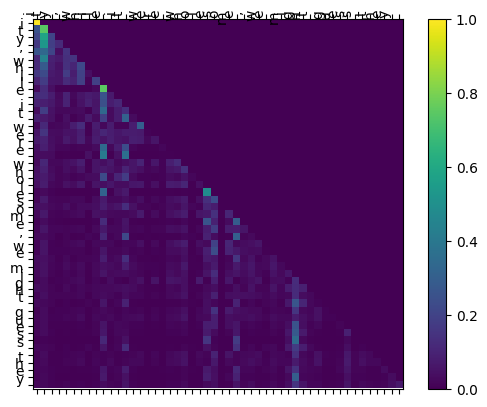

In [ ]:
plot(attention_weights)

In [ ]:
class Trainer():
    def __init__(self, model, train_loader, val_loader, optimizer, criterion):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epoch = 0
        self.optimizer = optimizer
        self.criterion = criterion
        train_loss = 0


    def train(self):
        self.model.train()
        total_loss = 0
        for x, y in self.train_loader:
            logits, attention_weights = self.model.forward(x, return_attention_weights=True)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            y = y.view(B*T)
            loss = self.criterion(logits, y)
            total_loss = total_loss + loss.item()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


        epoch_loss = total_loss / len(train_loader)
        self.epoch = self.epoch + 1
        print(f"Epoch: {self.epoch}\nTrain Loss: {epoch_loss}, Train Perplexity: {np.exp(epoch_loss)}, LR: {self.optimizer.param_groups[0]['lr']}")
        return epoch_loss

    @torch.no_grad()
    def validate(self):
        self.model.eval()
        total_loss = 0
        for x, y in self.val_loader:
            logits = self.model.forward(x)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            y = y.view(B*T)
            val_loss = self.criterion(logits, y)
            total_loss = total_loss + val_loss.item()

        epoch_loss = total_loss / len(self.val_loader)
        print(f'Validation Loss: {epoch_loss}')
        return epoch_loss

    @torch.no_grad()
    def generate(self, max_tokens, prompt, temperature = 1, top_p = 1):
        self.model.eval()
        for i in range(max_tokens):
            logits = self.model.forward(prompt)
            logit = logits[:, -1, :] # (B, C)
            logit = logit / temperature
            probs = F.softmax(logit, dim = -1)
            weighted_probs = self.topPTransform(probs, top_p)
            #token = torch.argmax(probs, dim = -1).view(-1, 1)
            token = torch.multinomial(weighted_probs, num_samples = 1) # (B, 1)
            prompt = torch.cat((prompt, token), dim = -1) # (B, T + 1)
        return prompt

    def topPTransform(self, probs, top_p):
        probs_sorted_vals, probs_sort_idx = torch.sort(probs, descending=True)
        prob_cumsum = torch.cumsum(probs_sorted_vals, dim = -1)

        absolute_diff = torch.abs(prob_cumsum - top_p)
        closest_index = torch.argmin(absolute_diff).item()
        idx_to_remove = probs_sort_idx[:, closest_index + 1:]

        mask = torch.ones_like(probs)
        mask[:, idx_to_remove] = 0

        probs = probs * mask
        weighted_probs = probs / torch.sum(probs, dim = -1)
        return weighted_probs




    def save(self, path):
        torch.save(self.model.state_dict(), path)
        print("Model saved at " + path)





In [ ]:
def wandb_config(epochs):
        d = dict()
        d['epochs'] = epochs
        d['lr'] = 1e-4

        return d


In [ ]:
import wandb
wandb.login(key="")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
epochs = 800
run = wandb.init(
    name = "shakGPT-decoder_3_512", ## Wandb creates random run names if you skip this field
    #reinit = True, ### Allows reinitalizing runs when you re-run this cell
    #run_id = "hr8c7o0i", ### Insert specific run id here if you want to resume a previous run
    resume = "True", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "shakespeare", ### Project should be created in your wandb account
    config = wandb_config(epochs) ### Wandb Config for your run
)

wandb: Currently logged in as: krana (llm-tuning). Use `wandb login --relogin` to force relogin


In [ ]:
trainer = Trainer(model = model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, criterion = criterion)
best_val_loss = float('inf')
for epoch in range(epochs):
    train_loss = trainer.train()
    val_loss = trainer.validate()
    #scheduler.step(val_loss)
    if val_loss < best_val_loss:
        trainer.save('/content/drive/MyDrive/ShakGPT_3_512.pt')
        best_val_loss = val_loss
    print("Generation: " + decode(trainer.generate(prompt =
                            torch.tensor(encode("BARNARDO: Who's there?\nFRANCISCO: Nay, answer me. Stand and unfold yourself.\nBARNARDO:")).view(1, -1).to(device),
                            max_tokens=170,
                            top_p = 0.7)[0].tolist()))
    wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'lr'        : optimizer.param_groups[0]['lr'],
        })

    print('\n')
    if epoch == 700:
        optimizer.param_groups[0]['lr'] = 1e-5

Epoch: 1
Train Loss: 1.8642677625020345, Train Perplexity: 6.451210337973911, LR: 0.0001
Validation Loss: 1.9744486808776855
Model saved at /content/drive/MyDrive/ShakGPT_3_512.pt
Generation: BARNARDO: Who's there?
FRANCISCO: Nay, answer me. Stand and unfold yourself.
BARNARDO:
I told you have some to my hand.

DUKE VINCENTIO:
What shall not have a sister from my father?

BUCKINGHAM:
Ay, my lord, and then, and the last dead.

DUKE VINCENTIO:
Br


Epoch: 2
Train Loss: 1.804576607545217, Train Perplexity: 6.077397779358238, LR: 0.0001
Validation Loss: 1.9553383588790894
Model saved at /content/drive/MyDrive/ShakGPT_3_512.pt
Generation: BARNARDO: Who's there?
FRANCISCO: Nay, answer me. Stand and unfold yourself.
BARNARDO:
I am a for bear the man.

DUKE VINCENTIO:
No bare you to be sense of all our tribunes;
For state hath me but a place to do.

PAULINA:
I have thee, then stand and more wi


Epoch: 3
Train Loss: 1.8078783988952636, Train Perplexity: 6.097497242633839, LR: 0.0001
Validation

KeyboardInterrupt: ignored

In [ ]:
from random import uniform
import time
from IPython.display import display, clear_output

def topPTransform(probs, top_p):
        probs_sorted_vals, probs_sort_idx = torch.sort(probs, descending=True)
        prob_cumsum = torch.cumsum(probs_sorted_vals, dim = -1)

        absolute_diff = torch.abs(prob_cumsum - top_p)
        closest_index = torch.argmin(absolute_diff).item()
        idx_to_remove = probs_sort_idx[:, closest_index + 1:]

        mask = torch.ones_like(probs)
        mask[:, idx_to_remove] = 0

        probs = probs * mask
        weighted_probs = probs / torch.sum(probs, dim = -1)
        return weighted_probs

def persistent_generation(prompt, max_tokens, temperature = 1, top_p = 1):
    generated_text = prompt
    model.eval()
    tokens = torch.tensor(encode(prompt)).reshape(1, -1).to(device)
    buffer = 10
    token_count = 0
    while token_count < max_tokens:
        if tokens.shape[-1] >= seq_len:
            tokens = tokens[:, tokens.shape[-1] - seq_len + 10: ]
        logits = model.forward(tokens)
        logit = logits[:, -1, :] # (B, C)

        # temperature
        logit = logit / temperature

        # top_p
        probs = F.softmax(logit, dim = -1) # (B, C)
        weighted_probs = topPTransform(probs, top_p)
        predicted_token = torch.multinomial(weighted_probs, num_samples = 1) # (B, 1)
        generated_text = generated_text + decode(predicted_token[0].cpu().detach().tolist())
        tokens = torch.cat((tokens, predicted_token), dim = -1) # (B, T + 1) # (1, 1)
        clear_output(wait=True)

        print(generated_text)
        token_count = token_count + 1

        #time.sleep(0.01)

print(persistent_generation("ACT I\n\nSCENE I. Elsinore. A platform before the Castle.\n\n\nEnter Francisco and Barnardo, two sentinels.", max_tokens = 700, top_p = 0.7))

ACT I

SCENE I. Elsinore. A platform before the Castle.


Enter Francisco and Barnardo, two sentinels.

KING HENRY VI:
Saw you will I know not where I was the defend?

HENRY BOLINGBROKE:
What you are you makes a gracious face?
And that I know not of the world bear you?

JOHN OF GAUNT:
And with me thee with that strength so trouble to thee,
Who should devotion me in means the bear.

KING RICHARD II:
What say you will prove this will come to any them?

BISHOP OF ELY:
What say you think?

GLOUCESTER:

Ghost of GARNE:

Ghost of Ghost of of Gloucester the house
of Gloucester of Gloucester house of the hand.

Ghost of GGORY:
Thou shalt have these thou stands of men
Thy slain to him and him of the house of a doint:
Which the was stay with my courteous to be death.

HENRY BOLINGBROKE:
She did not sh
None
